In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix,r2_score,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
warnings.filterwarnings("ignore")

In [47]:
data = pd.read_csv("/content/drive/MyDrive/Covid Data.csv")
print("Shape of data :",data.shape)
data.head()

Shape of data : (1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


**Tóm tắt Dataset**

Dataset bao gồm 21 unique features và 1.048.576 bệnh
nhân.  

Các ô giá trị 1&2: 1 là có, 2 là không.

Giá trị 97 và 99 bị thiếu dữ liệu.

Nếu bệnh nhân chưa chết ngày chết sẽ hiển thị giá trị 9999-99-99.

1. Chuẩn hoá dữ liệu

In [48]:
for i in data.columns:
    print(i,"=>\t",len(data[i].unique()))

USMER =>	 2
MEDICAL_UNIT =>	 13
SEX =>	 2
PATIENT_TYPE =>	 2
DATE_DIED =>	 401
INTUBED =>	 4
PNEUMONIA =>	 3
AGE =>	 121
PREGNANT =>	 4
DIABETES =>	 3
COPD =>	 3
ASTHMA =>	 3
INMSUPR =>	 3
HIPERTENSION =>	 3
OTHER_DISEASE =>	 3
CARDIOVASCULAR =>	 3
OBESITY =>	 3
RENAL_CHRONIC =>	 3
TOBACCO =>	 3
CLASIFFICATION_FINAL =>	 7
ICU =>	 4


In [49]:
data.DATE_DIED.value_counts()

DATE_DIED
9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       979
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: count, Length: 401, dtype: int64

In [50]:
data.PREGNANT.value_counts()

PREGNANT
97    523511
2     513179
1       8131
98      3754
Name: count, dtype: int64

In [51]:
data["ALIVE"]=[1 if i=="9999-99-99" else 0 for i in data["DATE_DIED"]]

In [52]:
data.drop("DATE_DIED",axis=1,inplace=True)

In [53]:
data["INFECTED"]=[1 if each<4 else 0 for each in data["CLASIFFICATION_FINAL"]]
data.drop("CLASIFFICATION_FINAL",axis=1,inplace=True)

In [54]:
null_or_non_zero_list=["USMER","SEX","PATIENT_TYPE","INTUBED","PNEUMONIA","PREGNANT","DIABETES","COPD","ASTHMA","INMSUPR","HIPERTENSION","OTHER_DISEASE","CARDIOVASCULAR","OBESITY","RENAL_CHRONIC","TOBACCO","ICU"]
for each in null_or_non_zero_list:
    data[each]=data[each].replace(2,0)
    data[each]=data[each].replace([97,99],98)

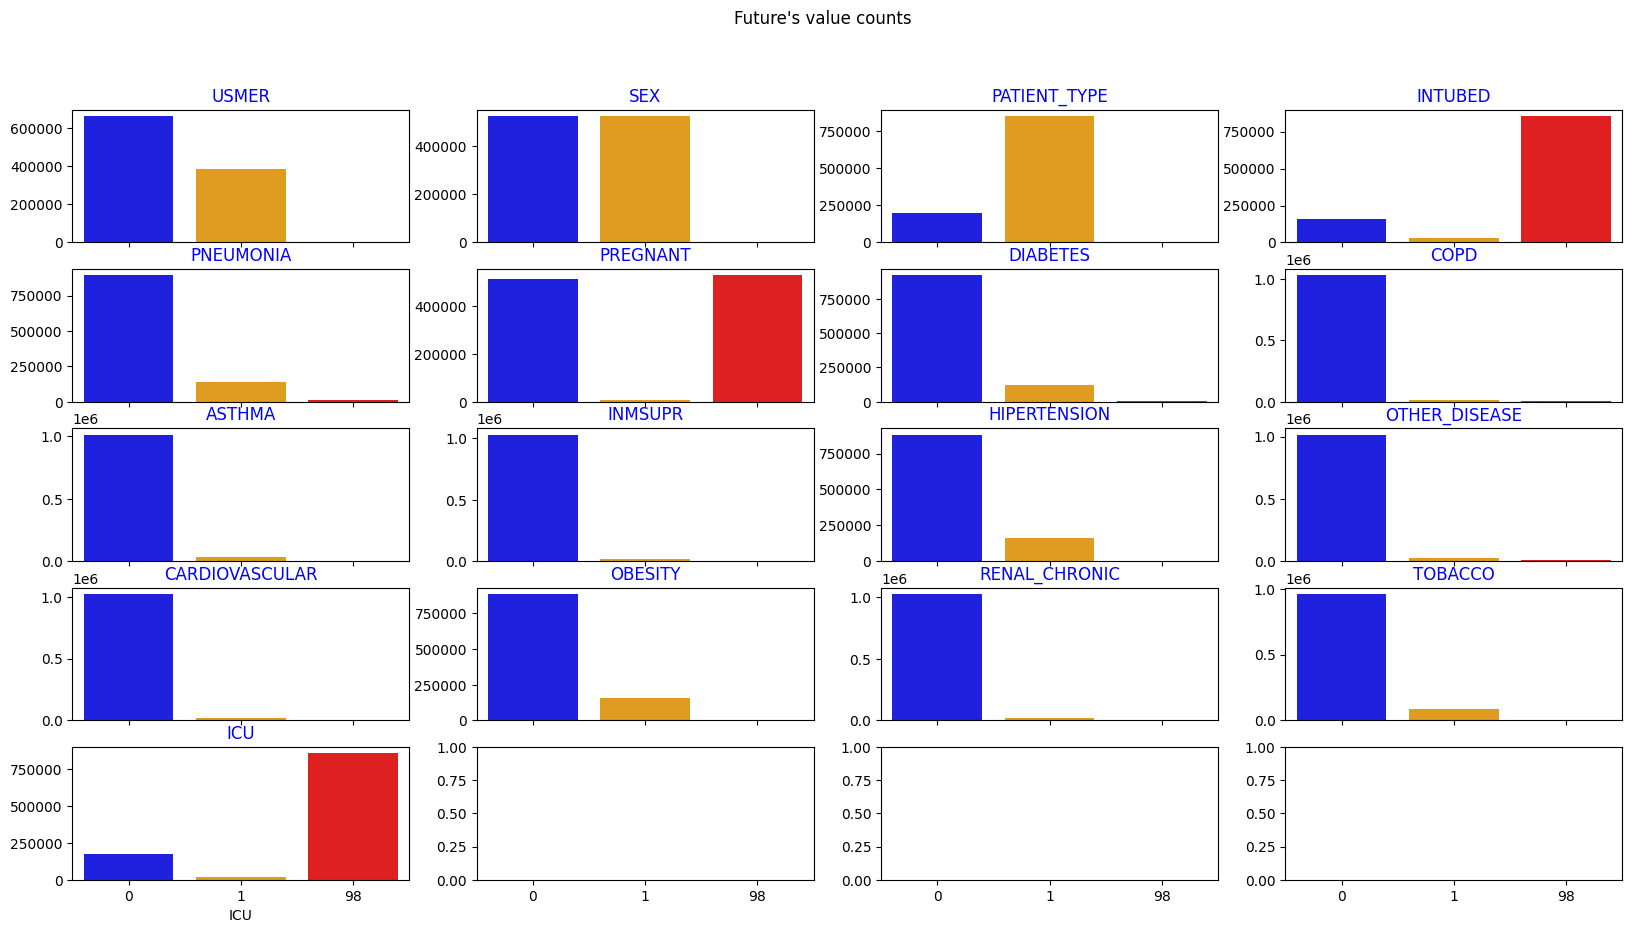

In [55]:
fig,axes=plt.subplots(5,4,sharex=True,figsize=(20,10))
fig.suptitle("Future's value counts")

a=0
b=0
for each in null_or_non_zero_list:
    sns.barplot(ax=axes[a][b],x=data[each].value_counts().index,y=data[each].value_counts().values,palette=["blue","orange","red"])
    axes[a][b].set_title(each,color="blue")
    b+=1
    if b>3:
        a+=1
        b=0

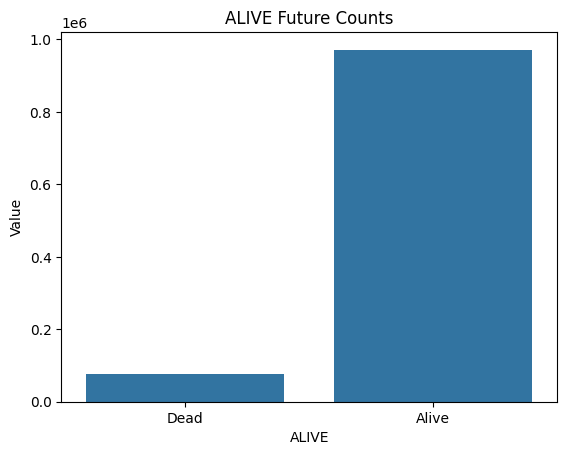

In [56]:
plt.figure()
sns.barplot(x=data.ALIVE.value_counts().index, y=data.ALIVE.value_counts().values).set(title="ALIVE Future Counts", xticklabels=["Dead", "Alive"], ylabel="Value")
plt.show()


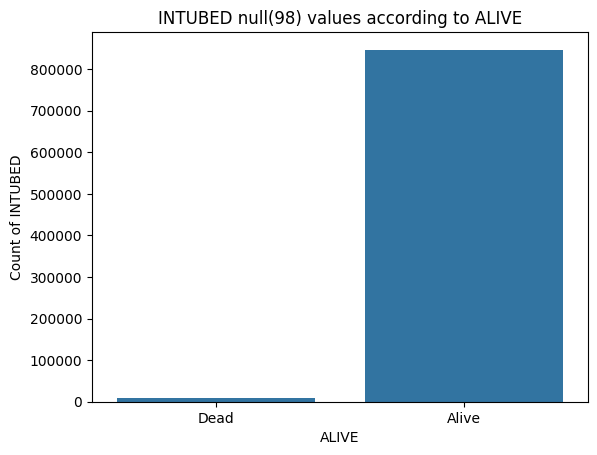

In [57]:
#Check the Intubed column and plot

plt.figure()
bar=sns.barplot(x=data.ALIVE[(data.INTUBED==98)].value_counts().index,y=data.ALIVE[(data.INTUBED==98)].value_counts().values)
bar.set(title="INTUBED null(98) values ​​according to ALIVE",
        xticklabels=(["Dead","Alive"]),
        ylabel="Count of INTUBED",
        xlabel="ALIVE")
plt.show()

In [58]:
data.drop(columns=["INTUBED"],inplace=True)
null_or_non_zero_list.remove("INTUBED")

In [59]:
print(data.PREGNANT[(data.SEX==0)&(data.PREGNANT==98)].value_counts())
data.PREGNANT[(data["SEX"]==0)&(data.PREGNANT==98)]=0

PREGNANT
98    523511
Name: count, dtype: int64


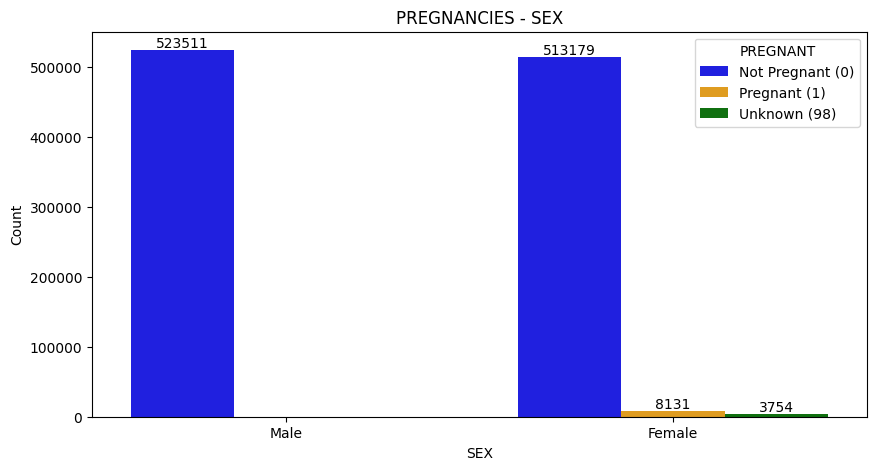

In [60]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=data.SEX, hue=data.PREGNANT, palette=["blue", "orange", "green"])
ax.set(title="PREGNANCIES - SEX", xlabel="SEX", ylabel="Count")
ax.set_xticklabels(["Male", "Female"])

for bars in ax.containers:
    ax.bar_label(bars)

plt.legend(title="PREGNANT", labels=["Not Pregnant (0)", "Pregnant (1)", "Unknown (98)"])
plt.show()

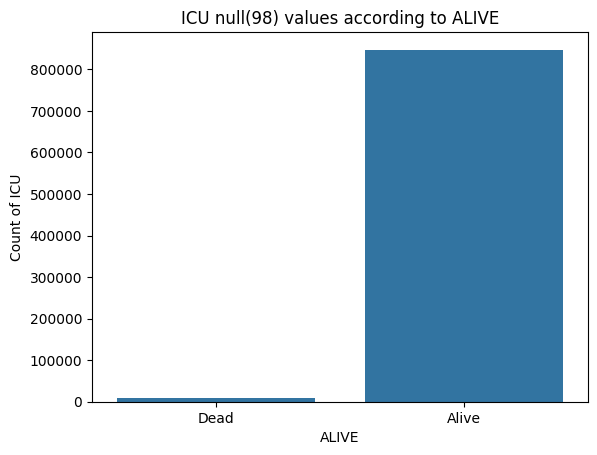

In [61]:
plt.figure()
bar=sns.barplot(x=data.ALIVE[(data.ICU==98)].value_counts().index,y=data.ALIVE[(data.ICU==98)].value_counts().values)
bar.set(title="ICU null(98) values ​​according to ALIVE",xticklabels=(["Dead","Alive"]),ylabel="Count of ICU",xlabel="ALIVE")
plt.show()

In [62]:
data.drop(columns=["ICU"],inplace=True)
null_or_non_zero_list.remove("ICU")

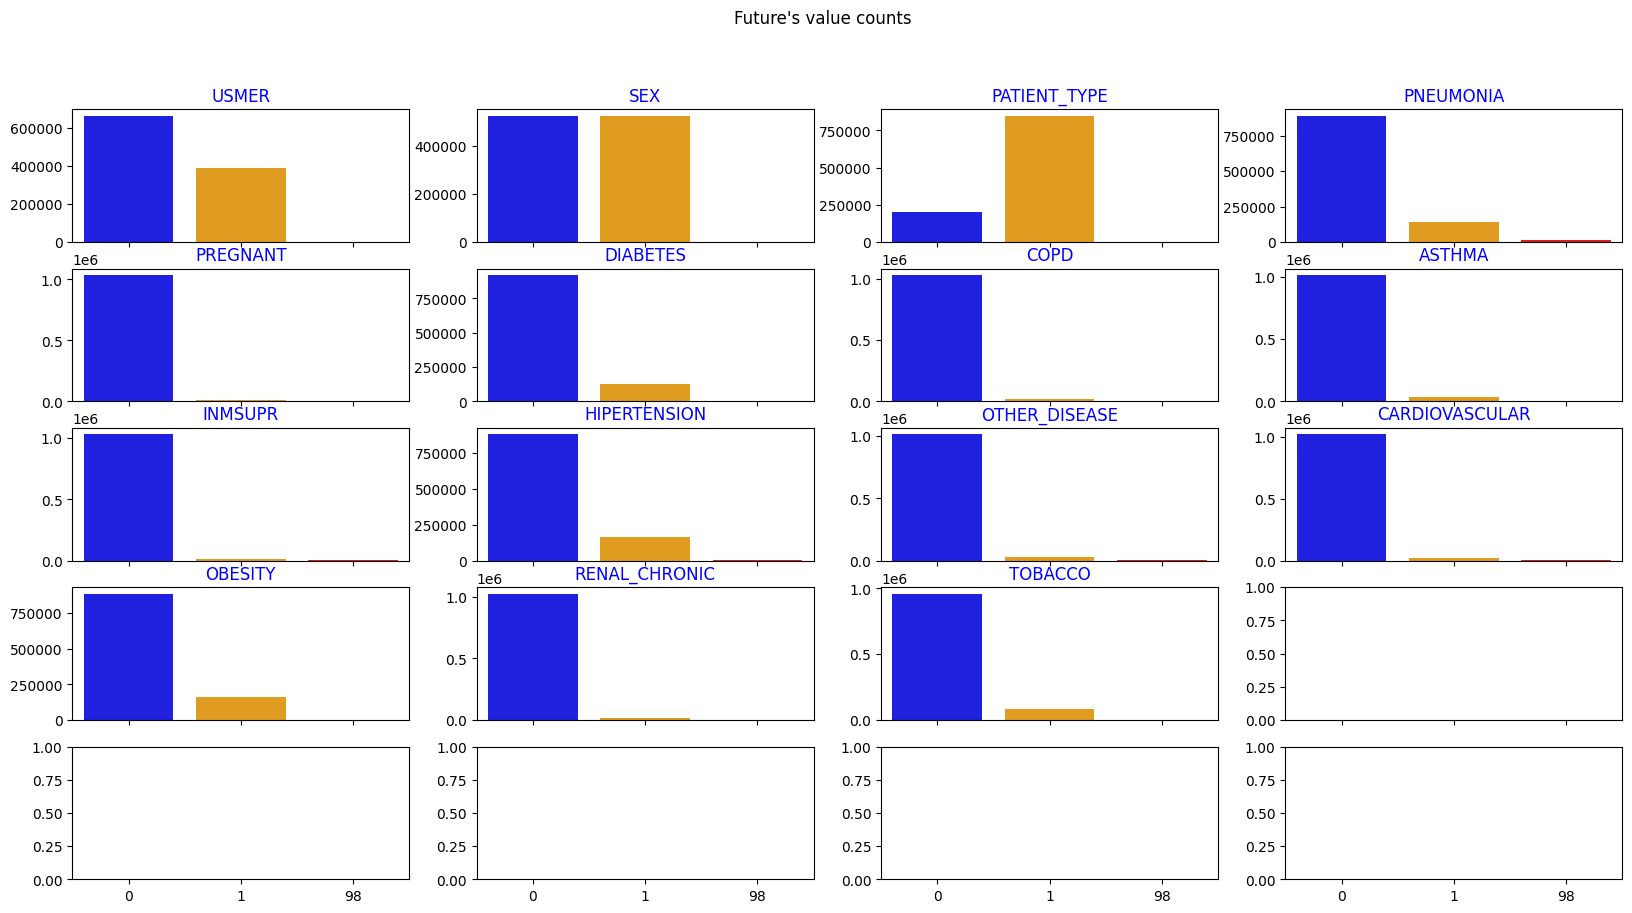

In [63]:
fig,axes=plt.subplots(5,4,sharex=True,figsize=(20,10))
fig.suptitle("Future's value counts")

a=0
b=0
for each in null_or_non_zero_list:
    sns.barplot(ax=axes[a][b],x=data[each].value_counts().index,y=data[each].value_counts().values,palette=["blue","orange","red"])
    axes[a][b].set_title(each,color="blue")
    b+=1
    if b>3:
        a+=1
        b=0

2. Trực quan hoá dữ liệu

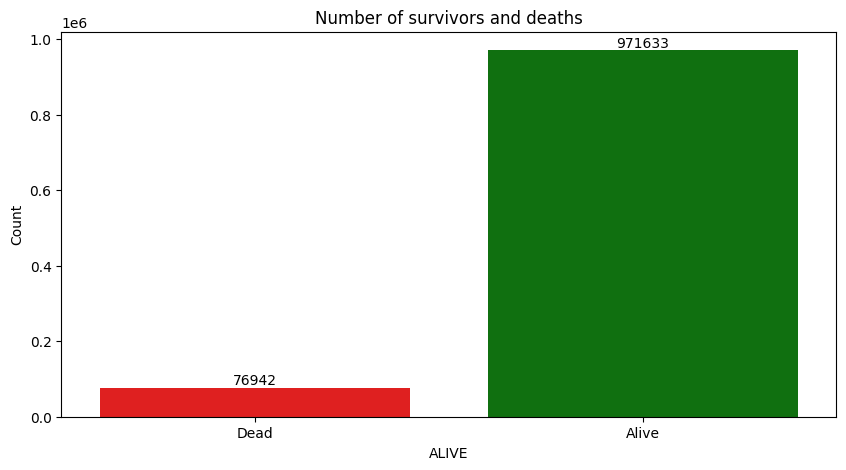

In [64]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=data.ALIVE, palette=["red", "green"])
ax.set(title="Number of survivors and deaths", xlabel="ALIVE", ylabel="Count")
ax.set_xticklabels(["Dead", "Alive"])

for bars in ax.containers:
    ax.bar_label(bars)

plt.show()

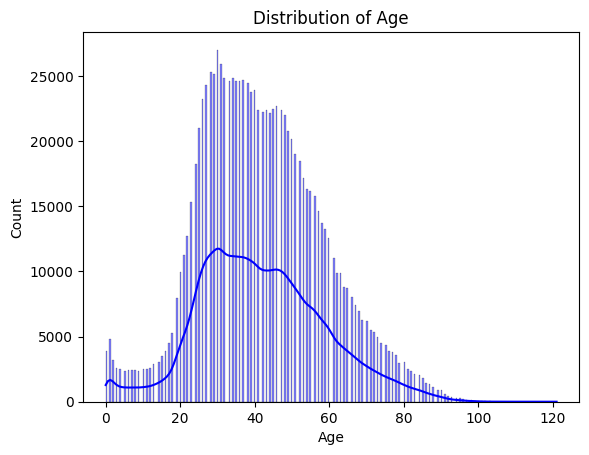

In [65]:
sns.histplot(x=data.AGE, kde=True, color="blue").set(title="Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

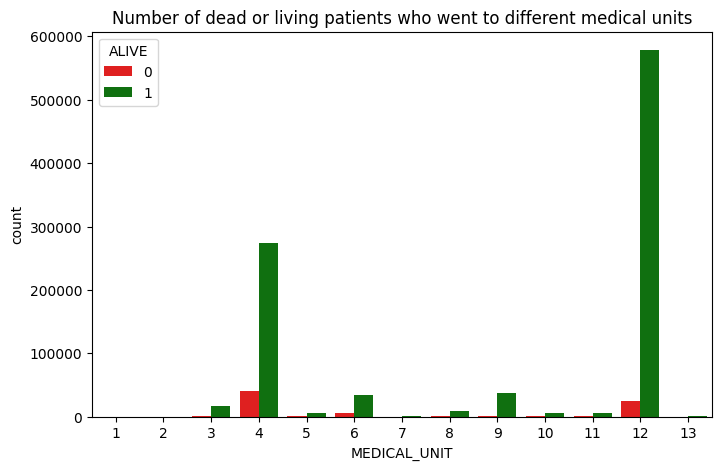

In [66]:
plt.figure(figsize=(8,5))
sns.countplot(x=data.MEDICAL_UNIT,hue=data.ALIVE,palette=["red","green"]).set(title="Number of dead or living patients who went to different medical units")
plt.show()

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   USMER           1048575 non-null  int64
 1   MEDICAL_UNIT    1048575 non-null  int64
 2   SEX             1048575 non-null  int64
 3   PATIENT_TYPE    1048575 non-null  int64
 4   PNEUMONIA       1048575 non-null  int64
 5   AGE             1048575 non-null  int64
 6   PREGNANT        1048575 non-null  int64
 7   DIABETES        1048575 non-null  int64
 8   COPD            1048575 non-null  int64
 9   ASTHMA          1048575 non-null  int64
 10  INMSUPR         1048575 non-null  int64
 11  HIPERTENSION    1048575 non-null  int64
 12  OTHER_DISEASE   1048575 non-null  int64
 13  CARDIOVASCULAR  1048575 non-null  int64
 14  OBESITY         1048575 non-null  int64
 15  RENAL_CHRONIC   1048575 non-null  int64
 16  TOBACCO         1048575 non-null  int64
 17  ALIVE           1048575 non

In [68]:
for i in data.columns:
    print(data[i].value_counts())
    print("\n")

USMER
0    662903
1    385672
Name: count, dtype: int64


MEDICAL_UNIT
12    602995
4     314405
6      40584
9      38116
3      19175
8      10399
10      7873
5       7244
11      5577
13       996
7        891
2        169
1        151
Name: count, dtype: int64


SEX
1    525064
0    523511
Name: count, dtype: int64


PATIENT_TYPE
1    848544
0    200031
Name: count, dtype: int64


PNEUMONIA
0     892534
1     140038
98     16003
Name: count, dtype: int64


AGE
30     27010
31     25927
28     25313
29     25134
34     24872
       ...  
114        2
116        2
111        1
121        1
113        1
Name: count, Length: 121, dtype: int64


PREGNANT
0     1036690
1        8131
98       3754
Name: count, dtype: int64


DIABETES
0     920248
1     124989
98      3338
Name: count, dtype: int64


COPD
0     1030510
1       15062
98       3003
Name: count, dtype: int64


ASTHMA
0     1014024
1       31572
98       2979
Name: count, dtype: int64


INMSUPR
0     1031001
1       14170
98 

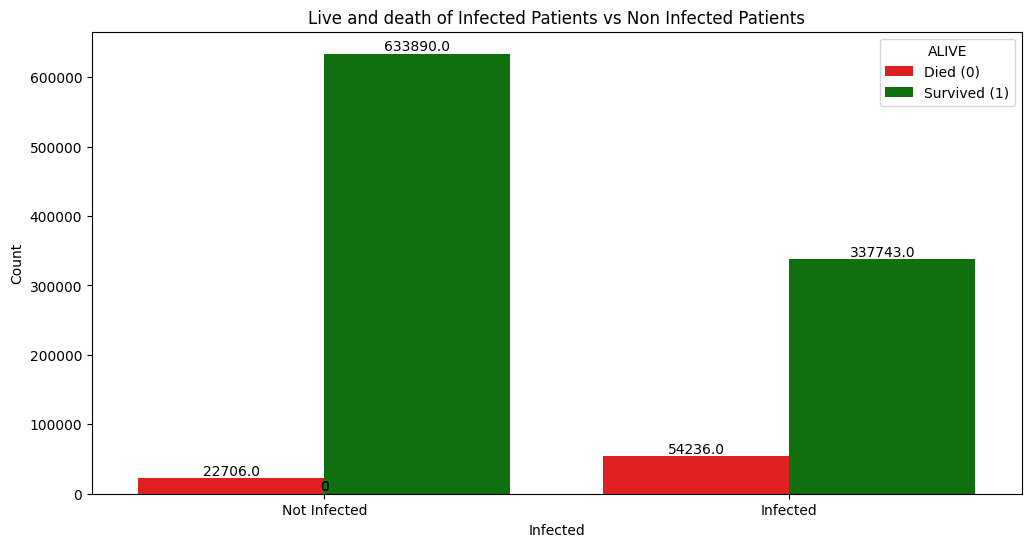

In [69]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=data.INFECTED, hue=data.ALIVE, palette=["red", "green"])
ax.set(title="Live and death of Infected Patients vs Non Infected Patients", xlabel="Infected", ylabel="Count")
ax.set_xticklabels(["Not Infected", "Infected"])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.legend(title="ALIVE", labels=["Died (0)", "Survived (1)"])
plt.show()

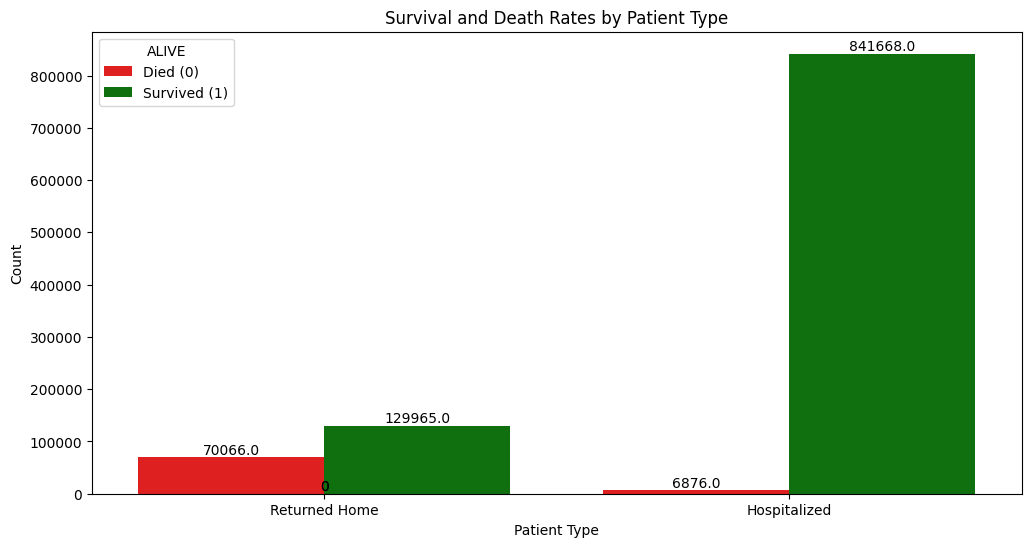

In [70]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=data.PATIENT_TYPE, hue=data.ALIVE, palette=["red", "green"])
ax.set(title="Survival and Death Rates by Patient Type", xlabel="Patient Type", ylabel="Count")
ax.set_xticklabels(["Returned Home", "Hospitalized"])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.legend(title="ALIVE", labels=["Died (0)", "Survived (1)"])
plt.show()

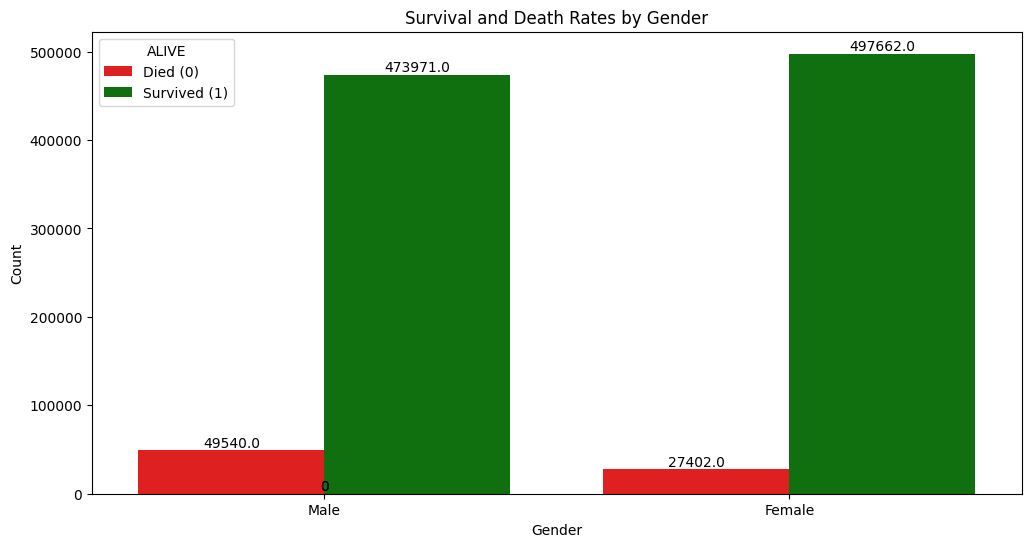

In [71]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=data.SEX, hue=data.ALIVE, palette=["red", "green"])
ax.set(title="Survival and Death Rates by Gender", xlabel="Gender", ylabel="Count")
ax.set_xticklabels(["Male", "Female"])

# Thêm nhãn số lượng lên các thanh
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Sửa chú thích
plt.legend(title="ALIVE", labels=["Died (0)", "Survived (1)"])
plt.show()

       Comorbidity  Total Cases  Death Cases  Death Rate
0        PNEUMONIA       140038        53923   38.505977
9    RENAL_CHRONIC        18904         5707   30.189378
2             COPD        15062         4021   26.696322
1         DIABETES       124989        28265   22.613990
7   CARDIOVASCULAR        20769         4435   21.353941
5     HIPERTENSION       162729        32061   19.702081
4          INMSUPR        14170         2618   18.475653
6    OTHER_DISEASE        28040         4546   16.212553
8          OBESITY       159816        17294   10.821194
10         TOBACCO        84376         6596    7.817389
3           ASTHMA        31572         1480    4.687698


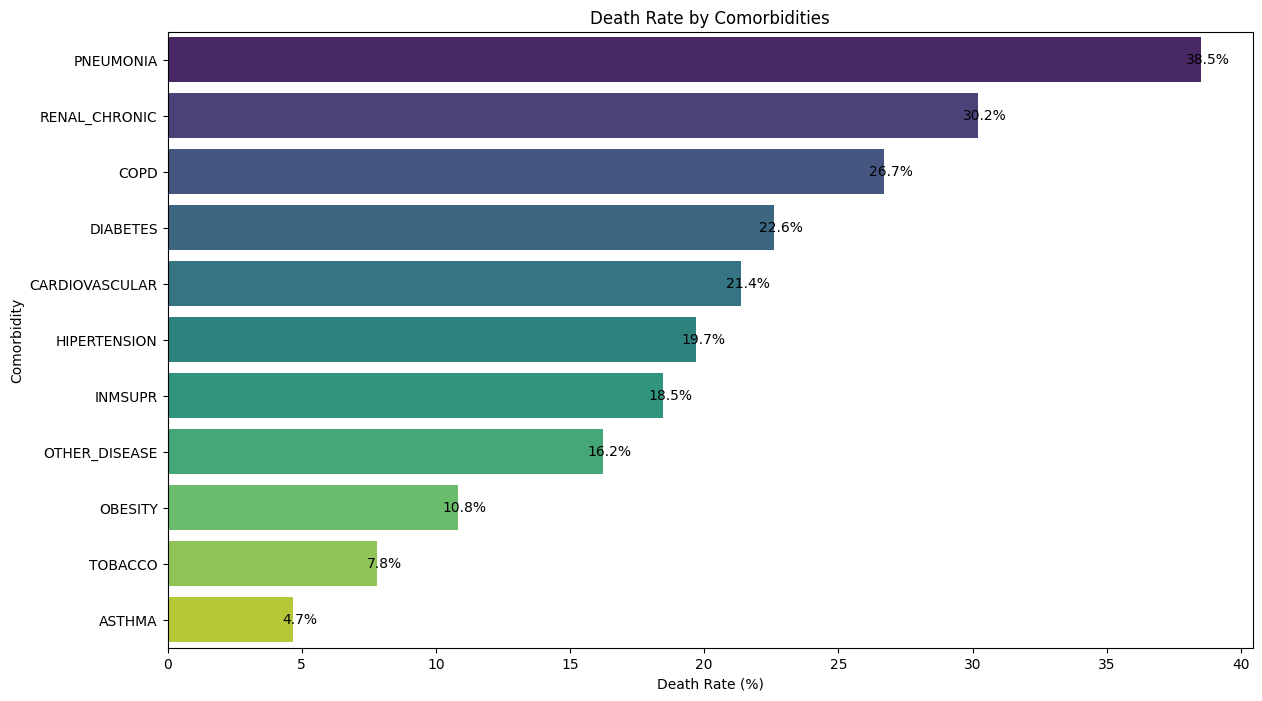

In [72]:
# Danh sách các yếu tố bệnh lý nền
comorbidities = ["PNEUMONIA", "DIABETES", "COPD", "ASTHMA", "INMSUPR",
                 "HIPERTENSION", "OTHER_DISEASE", "CARDIOVASCULAR",
                 "OBESITY", "RENAL_CHRONIC", "TOBACCO"]

# Tính tỷ lệ tử vong cho từng yếu tố bệnh lý nền
death_rates = []

for comorbidity in comorbidities:
    total_cases = data[data[comorbidity] == 1].shape[0]
    death_cases = data[(data[comorbidity] == 1) & (data.ALIVE == 0)].shape[0]
    death_rate = (death_cases / total_cases) * 100 if total_cases > 0 else 0
    death_rates.append([comorbidity, total_cases, death_cases, death_rate])

# Tạo bảng cho tỷ lệ tử vong
death_rate_df = pd.DataFrame(death_rates, columns=["Comorbidity", "Total Cases", "Death Cases", "Death Rate"])
death_rate_df = death_rate_df.sort_values(by="Death Rate", ascending=False)
print(death_rate_df)

#Plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(x="Death Rate", y="Comorbidity", data=death_rate_df, palette="viridis")
ax.set(title="Death Rate by Comorbidities", xlabel="Death Rate (%)", ylabel="Comorbidity")


for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.1f}%', (width, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

plt.show()


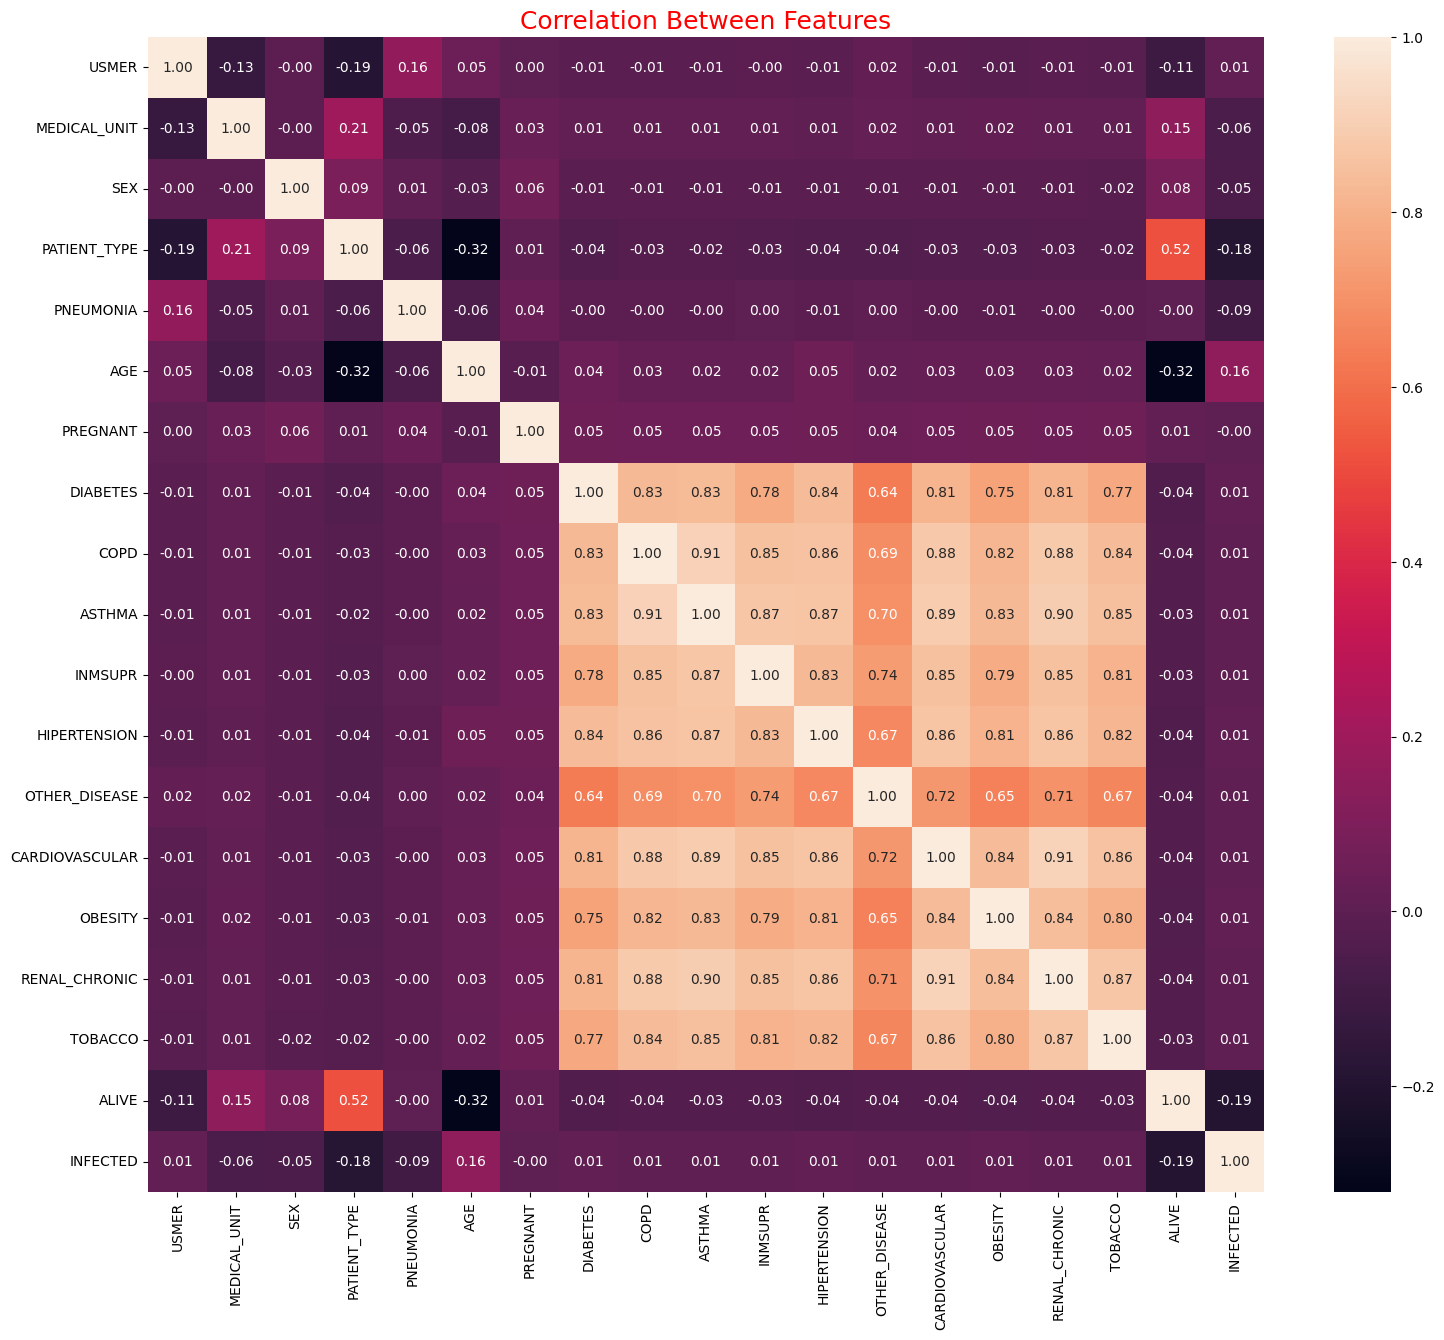

In [73]:
plt.figure(figsize=(18,15))
sns.heatmap(data.corr(),annot=True, fmt=".2f")
plt.title("Correlation Between Features",fontsize=18,color="red");

3. Why why need data balancing?

In [74]:
scaler = RobustScaler()
data.AGE = scaler.fit_transform(data.AGE.values.reshape(-1,1))
data.MEDICAL_UNIT=scaler.fit_transform(data.MEDICAL_UNIT.values.reshape(-1,1))

In [75]:
x=data.drop(columns="ALIVE")
y=data.ALIVE

In [76]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=42)
print("Train_x :",train_x.shape)
print("Test_x :",test_x.shape)
print("Train_y :",train_y.shape)
print("Test_y :",test_y.shape)

Train_x : (838860, 18)
Test_x : (209715, 18)
Train_y : (838860,)
Test_y : (209715,)


In [77]:
logreg = LogisticRegression()
logreg.fit(train_x,train_y)
print("Logistic Regression Accuracy :",logreg.score(test_x, test_y))
print("Logistic Regression F1 Score :",f1_score(test_y,logreg.predict(test_x),average=None))
print("Logistic Regression R2 Score: ",r2_score(test_y,logreg.predict(test_x)))


Logistic Regression Accuracy : 0.9350118017309206
Logistic Regression F1 Score : [0.45755224 0.96543539]
Logistic Regression R2 Score:  0.03562767414389445


In [78]:
rus = RandomUnderSampler(random_state=0)
x_resampled,y_resampled = rus.fit_resample(x,y)

Text(0.5, 1.0, 'Death Distribution After Resampling')

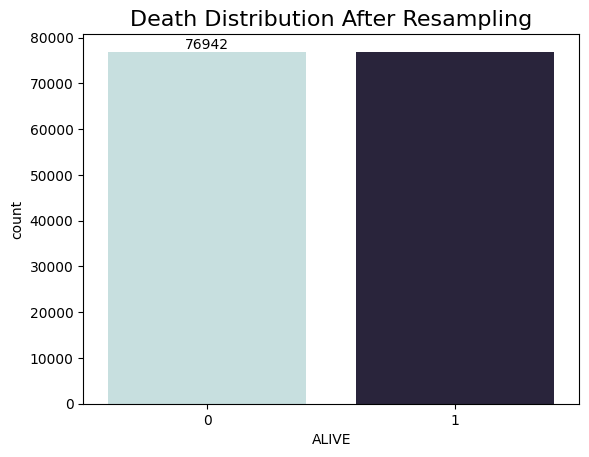

In [79]:
ax = sns.countplot(x=y_resampled,palette='ch:start=.2,rot=-.3')
plt.bar_label(ax.containers[0])
plt.title("Death Distribution After Resampling", fontsize=16)

5. Machine learning model compare

In [80]:
train_x, test_x, train_y, test_y = train_test_split(x_resampled,y_resampled, test_size=0.2, random_state=42)
print("Train_x :",train_x.shape)
print("Test_x :",test_x.shape)
print("Train_y :",train_y.shape)
print("Test_y :",test_y.shape)

Train_x : (123107, 18)
Test_x : (30777, 18)
Train_y : (123107,)
Test_y : (30777,)


In [81]:
logreg = LogisticRegression()
logreg.fit(train_x,train_y)
print("Logistic Regression Accuracy :",logreg.score(test_x, test_y))
print("Logistic Regression F1 Score :",f1_score(test_y,logreg.predict(test_x),average=None))
print("Logistic Regression R2 Score: ",r2_score(test_y,logreg.predict(test_x)))
#Better results

Logistic Regression Accuracy : 0.8930694999512623
Logistic Regression F1 Score : [0.89335364 0.89278384]
Logistic Regression R2 Score:  0.5722625448349562


In [84]:
rf=RandomForestClassifier(n_estimators=4,random_state=42)
rf.fit(train_x, train_y)
print("Random Forest Score: ",rf.score(test_x, test_y))
print("Random Forest F1 Score: ",f1_score(test_y,rf.predict(test_x),average=None))
print("Random Forest R2 Score: ",r2_score(test_y,rf.predict(test_x)))

Random Forest Score:  0.8955063846378789
Random Forest F1 Score:  [0.89816339 0.89270701]
Random Forest R2 Score:  0.5820104357913154


In [95]:
n=3
knn=KNeighborsClassifier(n_neighbors=n,n_jobs=-1)
knn.fit(train_x, train_y)
prediction=knn.predict(test_x)
print("{}nn Score: {}".format(n,knn.score(test_x, test_y)))
print("KNN F1 Score: ",f1_score(test_y,knn.predict(test_x),average=None))
print("KNN R2 Score: ",r2_score(test_y,knn.predict(test_x)))

3nn Score: 0.8947265815381616
KNN F1 Score:  [0.89645916 0.89293503]
KNN R2 Score:  0.5788911106852805


In [93]:
nb=GaussianNB()
nb.fit(train_x, train_y)
print("Naive Base Score: ",nb.score(test_x, test_y))
print("Naive Base F1 Score: ",f1_score(test_y,nb.predict(test_x),average=None))
print("Naive Base R2 Score: ",r2_score(test_y,nb.predict(test_x)))

Naive Base Score:  0.6429151639211099
Naive Base F1 Score:  [0.45588672 0.73425863]
Naive Base R2 Score:  -0.4283909548051752
